# Assignment 3: Pytorch Segmentation
For this assignment, we're goining to use Deep Learning for a new task: semantic segmentation , instead of classification we've been doing. We will also use some common techniques in Deep Learning like pretraining.

## Short recap of  semantic segmentation
The goal of semantic segmentation is to classify each pixel of the image to a corresponding class of what the pixel represent. One major deference between semantic segmentation and classification is that for semantic segmentation, model output label for each pixel instead of a single label for the whole image

### Metrics
In semantic segmentations, we will average pixel-wise accuracy and IoU to benchmark semantic segmentation methods. Here we provide, the code for Evaluation

In [12]:
import numpy as np

def _hist(pred, gt, n_class):
#     mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * gt.astype(int) +
        pred, minlength=n_class ** 2
    ).reshape(n_class, n_class)
    return hist


def metrics(preds, gts, n_class):
    hist = np.zeros((n_class, n_class))
    for pred, gt in zip(preds, gts):
        hist += _hist(pred.flatten(), gt.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    iou = np.diag(hist) / (
        hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
    )
    mean_iou = np.nanmean(iou)
    return acc, mean_iou

## CMP Facade DB
In this assignment, we use a new dataset named: CMP Facade Database for semantic segmentation. This dataset is made up with 606 rectified images of the facade of various buildings. The facades are from different cities arount the world with different architectural styles.

CMP Facade DB include 12 semantic classes:

* facade 
* molding
* cornice
* pillar
* window
* door
* sill
* blind
* balcony
* shop
* deco
* background

In this assignment, we should use a model to classify each pixel in images to one of these 12 classes.

For more detail about CMP Facade Dataset, if you are intereseted, please check: https://cmp.felk.cvut.cz/~tylecr1/facade/

## Visualize of the Dataset

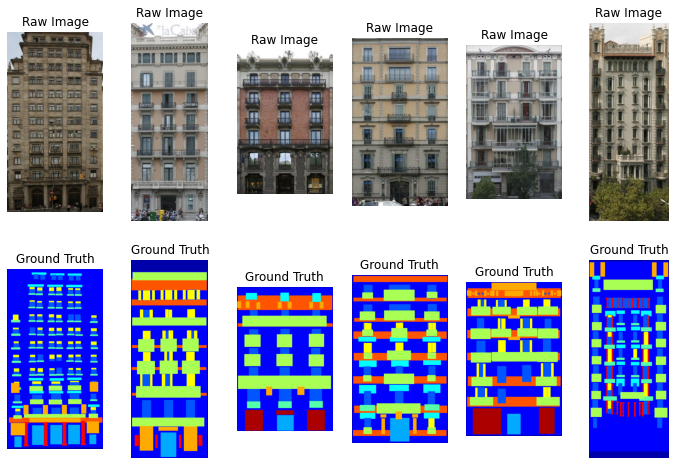

In [13]:
import matplotlib.pyplot as plt
import numpy as np
# import PI

idxs = [1, 2, 5, 6, 7, 8]
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 8))
for i, idx in enumerate(idxs):
    pic = plt.imread("dataset/base/cmp_b000{}.jpg".format(idx))
    label = plt.imread("dataset/base/cmp_b000{}.png".format(idx), format="PNG")

    axes[0][i].axis('off')
    axes[0][i].imshow(pic)
    axes[0][i].set_title("Raw Image")

    axes[1][i].imshow(label)
    axes[1][i].axis('off')
    axes[1][i].set_title("Ground Truth")


## Prepare

In [14]:
import torch
import copy

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


## Build Dataset Class in Pytorch

In [15]:
import torch
import PIL
from torch.utils.data import Dataset
import os
import os.path as osp
import torchvision.transforms as transforms
from PIL import Image


def get_full_list(
    root_dir,
    base_dir="base",
    extended_dir="extended",
):
    data_list = []
    for name in [base_dir, extended_dir]:
        data_dir = osp.join(
            root_dir, name
        )
        data_list += sorted(
            osp.join(data_dir, img_name) for img_name in
            filter(
                lambda x: x[-4:] == '.jpg',
                os.listdir(data_dir)
            )
        )
    return data_list

class CMP_Facade_DB(Dataset):
    def __init__(
        self,
        data_list
    ):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)
                
    def __getitem__(self, i):
        # input and target images
        in_name = self.data_list[i]
        gt_name = self.data_list[i].replace('.jpg','.png')
    
        # process the images
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        transf = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])
        in_image = transf(
            Image.open(in_name).convert('RGB')
        )
        gt_im = Image.open(gt_name)
        
        gt_label = torch.LongTensor(
            np.frombuffer(gt_im.tobytes(), dtype=np.ubyte).reshape(
                in_image.shape[1:]
            )
        ) - 1

        return in_image, gt_label
    
    def revert_input(self, img, label):
        img = np.transpose(img.cpu().numpy(), (1, 2, 0))
        std_img = np.array([0.229, 0.224, 0.225]).reshape((1, 1, -1))
        mean_img = np.array([0.485, 0.456, 0.406]).reshape((1, 1, -1))
        img *= std_img
        img += mean_img
        label = label.cpu().numpy()
        return img, label + 1

TRAIN_SIZE = 500
VAL_SIZE = 30
TEST_SIZE = 70
full_data_list = get_full_list("dataset")

train_data_set = CMP_Facade_DB(full_data_list[: TRAIN_SIZE])
val_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE])
test_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE + VAL_SIZE:])

print("Training Set Size:", len(train_data_set))
print("Validation Set Size:", len(val_data_set))
print("Test Set Size:", len(test_data_set))

Training Set Size: 500
Validation Set Size: 30
Test Set Size: 76


## Fully Convolutional Networks for Semantic Segmentation

We've seen that CNNs are powerful models to get hiereachical visual features in Deep Learning. There we are going to explore the classical work: "Fully Convolutional Networks for Semantic Segmentation"(FCN).

Though we've already used CNN models for image classifications in the previous assignemtn, those models have one major drawback: Those model take input with fixed shape and output a single vector. However, in semantic segmentation, we want the model to be able to process image with arbitary shape and predict the label map with the same shape as the input image.

In FCN, the model utilize the Transpose Convolution layers, which we've already learned during the lecture, to make it happen. For the overal introduction of Transpose Convolution and Fully Convolutional Networks, please review the lecture recording and lecture slides on Canvas(Lecture 10).

Here we do not cover all the details in FCN. If you need more reference, you can check the original paper: https://arxiv.org/pdf/1411.4038.pdf and some other materials online.

Besides of transpose Convolution, there are also some difference compared with the models we've been working on:

* Use 1x1 Convolution to replace fully connected layers to output score for each class.
* Use skip connection to combine high-level feature and local feature.


### Naive FCN: FCN-32s (30%)

In this section, we first try to implement naive variant of FCN without skip connection: FCN-32s. Here we use FCN-32s with VGG-16 architecture for feature encoding.

Compared with VGG-16, FCN-32s only replace the fully connecteed layers with 1x1 convolution and add a Transpose Convolution at the end to output dense prediction.


FC-32s architecture:

The following Conv use kernel size = 3, padding = 1, stride =1(except conv1_1. conv1_1 should use padding = 100)
The Max Pool should use "ceil_mode = True"

* [conv1_1(3,64)-relu] -> [conv1_2(64,64)-relu] -> [maxpool1(2,2)] 
* [conv2_1(64,128)-relu] -> [conv2_2(128,128)-relu] -> [maxpool2(2,2)]
* [conv3_1(128,256)-relu] -> [conv3_2(256,256)-relu] ->[conv3_3(256,256)-relu] ->  [maxpool3(2,2)]
* [conv4_1(256,512)-relu] -> [conv4_2(512,512)-relu] ->[conv4_3(512,512)-relu] ->  [maxpool3(2,2)]
* [conv5_1(512,512)-relu] -> [conv5_2(512,512)-relu] ->[conv5_3(512,512)-relu] ->  [maxpool3(2,2)]


The following Conv use kernel size = 7, stride = 1, padding = 0
* [fc6=conv(512, 4096, 7)-relu-dropout2d]

The following Conv use kernel size = 1, stride = 1, padding = 0
* [fc7=conv1x1(4096, 4096)-relu-dropout2d]
* [score=conv1x1(4096, num_classes)]

The transpose convolution: kernal size = 64, stride = 32, bias = False
* [transpose_conv(n_class, n_class)]

**Note: The output of the transpose convlution might not have the same shape as the input, take [19: 19 + input_image_width], [19: 19 + input_image_height] for width and height dimension of the output to get the output with the same shape as the input**

**It's expected that you model perform very poor in this section. This section is mainly for you to debug your code**

**Try to name the layers use the name provide above to ensure the next section works correctly, and use a new nn.RELU() for each activation**

**The model should achieve at least 40% Mean IoU for the pretrained version.**

In [16]:
import torch.nn as nn

def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

class FCN32s(nn.Module):
    def __init__(self, n_class=12):
        super(FCN32s, self).__init__()
        
        ################################################################################
        # TODO: Implement the layers for FCN32s.                                       #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.conv1_1 = nn.Conv2d(3 , 64, kernel_size=3, padding=100, stride=1)
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64 , 64, kernel_size=3, padding=1, stride=1)
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((2,2), ceil_mode=True)

        self.conv2_1 = nn.Conv2d(64 , 128, kernel_size=3, padding=1, stride=1)
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128 , 128, kernel_size=3, padding=1, stride=1)
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((2,2), ceil_mode=True)

        self.conv3_1 = nn.Conv2d(128 , 256, kernel_size=3, padding=1, stride=1)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256 , 256, kernel_size=3, padding=1, stride=1)
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256 , 256, kernel_size=3, padding=1, stride=1)
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d((2,2), ceil_mode=True)

        self.conv4_1 = nn.Conv2d(256 , 512, kernel_size=3, padding=1, stride=1)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512 , 512, kernel_size=3, padding=1, stride=1)
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512 , 512, kernel_size=3, padding=1, stride=1)
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d((2,2), ceil_mode=True)

        self.conv5_1 = nn.Conv2d(512 , 512, kernel_size=3, padding=1, stride=1)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512 , 512, kernel_size=3, padding=1, stride=1)
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512 , 512, kernel_size=3, padding=1, stride=1)
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d((2,2), ceil_mode=True)

        self.fc6 = nn.Conv2d(512,4096, kernel_size=7, stride=1, padding=0)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout2d()

        self.fc7 = nn.Conv2d(4096, 4096, kernel_size=1, stride=1, padding=0)
        self.relu7 = nn.ReLU()
        self.dropout7 = nn.Dropout2d()
        self.out = nn.Conv2d(4096, n_class, kernel_size=1, stride=1,padding=0)
        self.transpose1 = nn.ConvTranspose2d(n_class, n_class, 64, stride=32, bias=False)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################


        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 m.weight.data.zero_()
#                 if m.bias is not None:
#                     m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):

        ################################################################################
        # TODO: Implement the forward pass for FCN32s.                                 #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        H, W = x.shape[-2], x.shape[-1]
        # print('H,W',H,W)
        x = self.conv1_1(x)
        x = self.relu1_1(x)
        x = self.conv1_2(x)
        x = self.relu1_2(x)
        x = self.pool1(x)

        x = self.conv2_1(x)
        x = self.relu2_1(x)
        x = self.conv2_2(x)
        x = self.relu2_2(x)
        x = self.pool2(x)

        x = self.conv3_1(x)
        x = self.relu3_1(x)
        x = self.conv3_2(x)
        x = self.relu3_2(x)
        x = self.pool3(x)

        x = self.conv4_1(x)
        x = self.relu4_1(x)
        x = self.conv4_2(x)
        x = self.relu4_2(x)
        x = self.pool4(x)

        x = self.conv5_1(x)
        x = self.relu5_1(x)
        x = self.conv5_2(x)
        x = self.relu5_2(x)
        x = self.pool5(x)

        x = self.fc6(x)
        x = self.relu6(x)
        x = self.dropout6(x)

        x = self.fc7(x)
        x = self.relu7(x)
        x = self.dropout7(x)
        x = self.out(x)
        x = self.transpose1(x)
        h = x[...,19:H+19,19:W+19]
        # print('h',h.shape)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        
        return h

    
    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())


In [17]:
# You can change it if you want
lr = 1e-4
weight_decay = 2e-5

In [18]:
train_loader = torch.utils.data.DataLoader(
    train_data_set, batch_size=1, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_data_set, batch_size=1, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data_set, batch_size=1, shuffle=True
)

In [19]:
def Evaluate(
    val_loader,
    model,
    current_best,
    n_class=12
):
    val_loss = 0
    visualizations = []
    preds, gts = [], []
    
    model.eval()
    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            score = model(data)

        pred = score.max(1)[1].cpu().numpy()
        gt = target.cpu().numpy()
        preds.append(pred)
        gts.append(gt)

    avg_acc, mean_iou = metrics(
        preds, gts, n_class)

    if mean_iou > current_best["IoU"]:
        current_best["IoU"] = mean_iou
        current_best["model"] = copy.deepcopy(model)

    return avg_acc, mean_iou, current_best

def Train(
    model,
    loss_func,
    optim,
    scheduler,
    epochs,
    train_loader,
    val_lodaer,
    test_loader,
    display_interval = 100
):

    current_best = {
        "IoU": 0,
        "model": model
    }
    avg_acc, mean_iou, current_best = Evaluate(
        val_loader,
        model,
        current_best
    )
    
    print("Init Model")
    print("Avg Acc: {:.4}, Mean IoU: {:.4}".format(
        avg_acc, mean_iou
    ))
    for i in range(epochs):
        print("Epochs: {}".format(i))
        total_loss = 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to("cuda:0"), target.to("cuda:0")
            optim.zero_grad()

            score = model(data)
            loss = loss_func(score, target.squeeze(1))
            loss_data = loss.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            loss.backward()
            optim.step()
            total_loss += loss.item()
            if batch_idx % display_interval == 0 and batch_idx != 0:
                print("{} / {}, Current Avg Loss:{:.4}".format(
                    batch_idx, len(train_loader), total_loss / (batch_idx + 1)
                ))
            
        
        total_loss /= len(train_loader)
        model.eval()
        avg_acc, mean_iou, current_best = Evaluate(
            val_loader,
            model,
            current_best
        )
        scheduler.step(total_loss)
        print("Avg Loss: {:.4}, Avg Acc: {:.4}, Mean IoU: {:.4}".format(
            total_loss, avg_acc, mean_iou
        ))
    
    test_acc, test_iou, current_best = Evaluate(
        val_loader,
        current_best["model"],
        current_best
    )
    print("Test Acc: {:.4}, Test Mean IoU: {:.4}".format(
        test_acc, test_iou
    ))
    return current_best["model"]

In [9]:
model = FCN32s(n_class=12)
model.to(device)

optim = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optim, 'min', patience=3,
    min_lr=1e-10, verbose=True
)

# Choose the right loss function in torch.nn
loss_func = nn.CrossEntropyLoss()
best_model = Train(
    model,
    loss_func,
    optim,
    scheduler,
    5,
    train_loader,
    val_loader,
    test_loader
)

<ipython-input-4-4da76993cd6a>:56: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  gt_label = torch.LongTensor(


Init Model
Avg Acc: 0.02884, Mean IoU: 0.002403
Epochs: 0
100 / 500, Current Avg Loss:1.996
200 / 500, Current Avg Loss:1.97
300 / 500, Current Avg Loss:1.943
400 / 500, Current Avg Loss:1.917
Avg Loss: 1.892, Avg Acc: 0.3675, Mean IoU: 0.04041
Epochs: 1
100 / 500, Current Avg Loss:1.779
200 / 500, Current Avg Loss:1.772
300 / 500, Current Avg Loss:1.763
400 / 500, Current Avg Loss:1.763
Avg Loss: 1.757, Avg Acc: 0.4375, Mean IoU: 0.06889
Epochs: 2
100 / 500, Current Avg Loss:1.752
200 / 500, Current Avg Loss:1.742
300 / 500, Current Avg Loss:1.746
400 / 500, Current Avg Loss:1.734
Avg Loss: 1.723, Avg Acc: 0.4471, Mean IoU: 0.07259
Epochs: 3
100 / 500, Current Avg Loss:1.671
200 / 500, Current Avg Loss:1.68
300 / 500, Current Avg Loss:1.682
400 / 500, Current Avg Loss:1.683
Avg Loss: 1.686, Avg Acc: 0.4428, Mean IoU: 0.07453
Epochs: 4
100 / 500, Current Avg Loss:1.668
200 / 500, Current Avg Loss:1.66
300 / 500, Current Avg Loss:1.657
400 / 500, Current Avg Loss:1.634
Avg Loss: 1.616, 

#### Visualize Output
In this section, we visualize several model outputs to see how our model actually perform.

In [21]:
def visualize(model, test_loader):
    idxs = [1, 2, 5, 6, 7, 8]
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(12, 8))
    model.eval()
    for i, idx in enumerate(idxs):
        img, label = test_loader.dataset[idx]
        
        pred = model(img.unsqueeze(0).to(device)) 
        pred = (pred.max(1)[1] + 1).squeeze(0).cpu().numpy()
        
        img, label = test_loader.dataset.revert_input(img, label)
        
        axes[0][i].axis('off')
        axes[0][i].imshow(img)
        axes[0][i].set_title("Raw Image")

        axes[1][i].imshow(label)
        axes[1][i].axis('off')
        axes[1][i].set_title("Ground Truth")

        axes[2][i].imshow(pred)
        axes[2][i].axis('off')
        axes[2][i].set_title("prediction")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


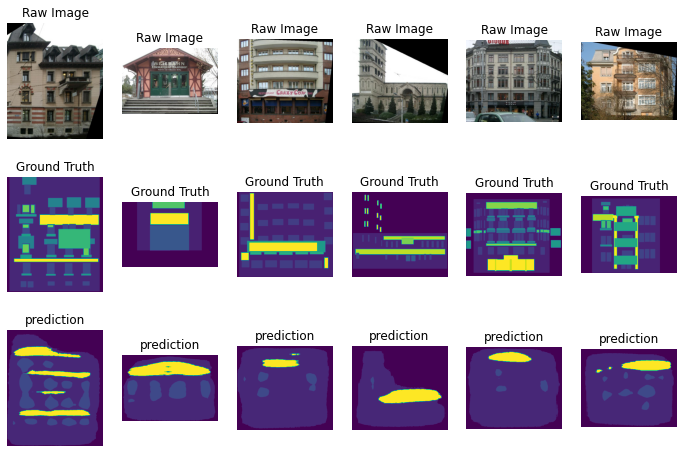

In [11]:
visualize(best_model, test_loader)

## Utilize the pretrain features

In the previous section, we use the random initalized weights to train FCN-32S from scrath. We can see that it perform poorly. In this section, we utilize the feature from pretrained model(In our case, we use VGG-16) to help us get a better result.

In [14]:
import torchvision
vgg16 = torchvision.models.vgg16(pretrained=True)

model = FCN32s(n_class=12)
model.copy_params_from_vgg16(vgg16)
model.to(device)




optim = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optim, 'min', patience=3,
    min_lr=1e-10, verbose=True
)

loss_func = nn.CrossEntropyLoss()
best_model_pretrain = Train(
    model,
    loss_func,
    optim,
    scheduler,
    25,
    train_loader,
    val_loader,
    test_loader
)

<ipython-input-6-4da76993cd6a>:56: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  gt_label = torch.LongTensor(


Init Model
Avg Acc: 0.004432, Mean IoU: 0.001011
Epochs: 0
100 / 500, Current Avg Loss:1.911
200 / 500, Current Avg Loss:1.779
300 / 500, Current Avg Loss:1.709
400 / 500, Current Avg Loss:1.675
Avg Loss: 1.621, Avg Acc: 0.5524, Mean IoU: 0.1842
Epochs: 1
100 / 500, Current Avg Loss:1.358
200 / 500, Current Avg Loss:1.334
300 / 500, Current Avg Loss:1.315
400 / 500, Current Avg Loss:1.311
Avg Loss: 1.299, Avg Acc: 0.5582, Mean IoU: 0.1938
Epochs: 2
100 / 500, Current Avg Loss:1.239
200 / 500, Current Avg Loss:1.226
300 / 500, Current Avg Loss:1.225
400 / 500, Current Avg Loss:1.191
Avg Loss: 1.184, Avg Acc: 0.6043, Mean IoU: 0.2566
Epochs: 3
100 / 500, Current Avg Loss:1.061
200 / 500, Current Avg Loss:1.068
300 / 500, Current Avg Loss:1.08
400 / 500, Current Avg Loss:1.079
Avg Loss: 1.068, Avg Acc: 0.598, Mean IoU: 0.2826
Epochs: 4
100 / 500, Current Avg Loss:0.9962
200 / 500, Current Avg Loss:0.9851
300 / 500, Current Avg Loss:1.001
400 / 500, Current Avg Loss:0.9915
Avg Loss: 0.9846

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


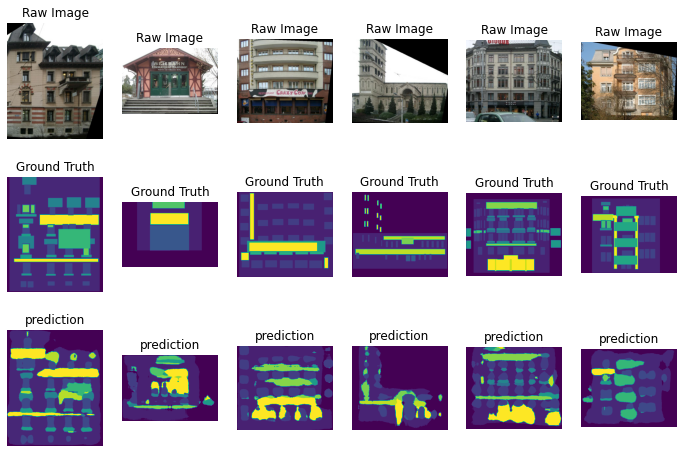

In [15]:
visualize(best_model_pretrain, test_loader)

## Skip Connection: FCN-8s(40%)

Though we've get a prety good result using FCN-32s with VGG-16 pretrain. We can actully do better with another technique introduced in FCN paper: Skip Connection. 

With skip connection, we are supposed to get a better performance especially for some details.

Here we provide the structure of FCN-8s, the variant of FCN with skip connections.

FCN-8s architecture:

The following Conv use kernel size = 3, padding = 1, stride =1(except conv1_1. conv1_1 should use padding = 100)
The Max Pool should use "ceil_mode = True"

 **As you can see, the structure of this part is the same as FCN-32s**


* [conv1_1(3,64)-relu] -> [conv1_2(64,64)-relu] -> [maxpool1(2,2)] 
* [conv2_1(64,128)-relu] -> [conv2_2(128,128)-relu] -> [maxpool2(2,2)]
* [conv3_1(128,256)-relu] -> [conv3_2(256,256)-relu] ->[conv3_3(256,256)-relu] -> [maxpool3(2,2)]
* [conv4_1(256,512)-relu] -> [conv4_2(512,512)-relu] ->[conv4_3(512,512)-relu] -> [maxpool3(2,2)]
* [conv5_1(512,512)-relu] -> [conv5_2(512,512)-relu] ->[conv5_3(512,512)-relu] -> [maxpool3(2,2)]

The following Conv use kernel size = 7, stride = 1, padding = 0
* [fc6=conv(512, 4096, 7)-relu-dropout2d]

The following Conv use kernel size = 1, stride = 1, padding = 0
* [fc7=conv1x1(4096, 4096)-relu-dropout2d]
* [score=conv1x1(4096, num_classes)]

The Additional Score Pool use kernel size = 1, stride = 1, padding = 0
* [score_pool_3 =conv1x1(256, num_classes)]
* [score_pool_4 =conv1x1(512, num_classes)]

The transpose convolution: kernel size = 4, stride = 2, bias = False
* [upscore1 = transpose_conv(n_class, n_class)]

The transpose convolution: kernel size = 4, stride = 2, bias = False
* [upscore2 = transpose_conv(n_class, n_class)]

The transpose convolution: kernel size = 16, stride = 8, bias = False
* [upscore3 = transpose_conv(n_class, n_class)]

Different from FCN-32s which has only single path from input to output, there are multiple data path from input to output in FCN-8s.

The following graph is from original FCN paper, you can also find the graph there.

!["Architecture Graph"](arch.png)
"Layers are shown as grids that reveal relative spatial coarseness. Only pooling and prediction layers are shown; intermediate convolution layers (including converted fully connected layers) are omitted. " ---- FCN

Detailed path specification:

* score_pool_3
    * input: output from layer "pool3"
    * take [9: 9 + upscore2_width], [9: 9 + upscore2_height]
    
* score_pool_4,
    * input: output from layer "pool4"
    * take [5: 5 + upscore1_width], [5: 5 + upscore1_height]


* upscore1
    * input: output from layer "score"

* upscore2:
    * input: output from layer "score_pool_4" + output from layer "upscore1"

* upscore3:
    * input: output from layer "score_pool_3" + output from layer "upscore2"
    * take [31: 31 + input_image_width], [31: 31 + input_image_height]


**The model should achieve at least 40% Mean IoU**


In [9]:
import torch.nn as nn

class FCN8s(nn.Module):

    def __init__(self, n_class=12):
        super(FCN8s, self).__init__()

        ################################################################################
        # TODO: Implement the layers for FCN8s.                                        #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.conv1_1 = nn.Conv2d(3 , 64, kernel_size=3, padding=100, stride=1)
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64 , 64, kernel_size=3, padding=1, stride=1)
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((2,2), ceil_mode=True)

        self.conv2_1 = nn.Conv2d(64 , 128, kernel_size=3, padding=1, stride=1)
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128 , 128, kernel_size=3, padding=1, stride=1)
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((2,2), ceil_mode=True)

        self.conv3_1 = nn.Conv2d(128 , 256, kernel_size=3, padding=1, stride=1)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256 , 256, kernel_size=3, padding=1, stride=1)
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256 , 256, kernel_size=3, padding=1, stride=1)
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d((2,2), ceil_mode=True)

        self.conv4_1 = nn.Conv2d(256 , 512, kernel_size=3, padding=1, stride=1)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512 , 512, kernel_size=3, padding=1, stride=1)
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512 , 512, kernel_size=3, padding=1, stride=1)
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d((2,2), ceil_mode=True)

        self.conv5_1 = nn.Conv2d(512 , 512, kernel_size=3, padding=1, stride=1)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512 , 512, kernel_size=3, padding=1, stride=1)
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512 , 512, kernel_size=3, padding=1, stride=1)
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d((2,2), ceil_mode=True)

        self.fc6 = nn.Conv2d(512,4096, kernel_size=7, stride=1, padding=0)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout2d()

        self.fc7 = nn.Conv2d(4096, 4096, kernel_size=1, stride=1, padding=0)
        self.relu7 = nn.ReLU()
        self.dropout7 = nn.Dropout2d()

        self.transpose1 = nn.ConvTranspose2d(n_class, n_class, 64, stride=32, bias=False)

        self.score = nn.Conv2d(4096, n_class, kernel_size=1, stride=1,padding=0)
        self.score_pool_3 = nn.Conv2d(256,n_class, kernel_size=1, stride=1,padding=0)
        self.score_pool_4 = nn.Conv2d(512,n_class, kernel_size=1, stride=1,padding=0)

        self.upscore1 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)
        self.upscore2 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)
        self.upscore3 = nn.ConvTranspose2d(n_class, n_class, 16, stride=8, bias=False)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            # if isinstance(m, nn.Conv2d):
            #     m.weight.data.zero_()
            #     if m.bias is not None:
            #         m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

                
    def forward(self, x):

        ################################################################################
        # TODO: Implement the forward pass for FCN8s.                                 #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        H, W = x.shape[-2], x.shape[-1]
        # print('H,W',H,W)
        x = self.conv1_1(x)
        x = self.relu1_1(x)
        x = self.conv1_2(x)
        x = self.relu1_2(x)
        x = self.pool1(x)

        x = self.conv2_1(x)
        x = self.relu2_1(x)
        x = self.conv2_2(x)
        x = self.relu2_2(x)
        x = self.pool2(x)

        x = self.conv3_1(x)
        x = self.relu3_1(x)
        x = self.conv3_2(x)
        x = self.relu3_2(x)
        x = self.pool3(x)
        score_pool_3 = self.score_pool_3(x)


        x = self.conv4_1(x)
        x = self.relu4_1(x)
        x = self.conv4_2(x)
        x = self.relu4_2(x)
        x = self.pool4(x)
        score_pool_4 = self.score_pool_4(x)

        x = self.conv5_1(x)
        x = self.relu5_1(x)
        x = self.conv5_2(x)
        x = self.relu5_2(x)
        x = self.pool5(x)


        x = self.fc6(x)
        x = self.relu6(x)
        x = self.dropout6(x)

        x = self.fc7(x)
        x = self.relu7(x)
        x = self.dropout7(x)
        x = self.score(x)

        upscore1 = self.upscore1(x)
        upscore1_h, upscore1_w = upscore1.shape[-2], upscore1.shape[-1]
        upscore2 = self.upscore2(score_pool_4[...,5:5+upscore1_h, 5:5+upscore1_w] + upscore1)
        upscore2_h, upscore2_w = upscore2.shape[-2], upscore2.shape[-1]
        upscore3 = self.upscore3(score_pool_3[...,9:9+upscore2_h, 9:9+upscore2_w] +
                                 upscore2)[...,31:31+H,31:31+W]

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################


        return upscore3

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data.copy_(l1.weight.data)
                l2.bias.data.copy_(l1.bias.data)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))


In [ ]:
import torchvision
vgg16 = torchvision.models.vgg16(pretrained=True)

model = FCN8s(n_class=12)
model.copy_params_from_vgg16(vgg16)
model.to(device)

optim = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
#     momentum=momentum,
)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optim, 'min', patience=3,
    min_lr=1e-10, verbose=True
)
loss_func = nn.CrossEntropyLoss()
best_model_fcn8s = Train(
    model,
    loss_func,
    optim,
    scheduler,
    25,
    train_loader,
    val_loader,
    test_loader
)



<ipython-input-4-4da76993cd6a>:56: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  gt_label = torch.LongTensor(


Init Model
Avg Acc: 0.06052, Mean IoU: 0.01811
Epochs: 0
100 / 500, Current Avg Loss:1.741
200 / 500, Current Avg Loss:1.576
300 / 500, Current Avg Loss:1.478
400 / 500, Current Avg Loss:1.403
Avg Loss: 1.361, Avg Acc: 0.5749, Mean IoU: 0.2668
Epochs: 1
100 / 500, Current Avg Loss:1.138
200 / 500, Current Avg Loss:1.131
300 / 500, Current Avg Loss:1.107
400 / 500, Current Avg Loss:1.109
Avg Loss: 1.099, Avg Acc: 0.6194, Mean IoU: 0.2866
Epochs: 2
100 / 500, Current Avg Loss:1.028
200 / 500, Current Avg Loss:1.029
300 / 500, Current Avg Loss:1.005
400 / 500, Current Avg Loss:1.007
Avg Loss: 0.9933, Avg Acc: 0.6546, Mean IoU: 0.3441
Epochs: 3
100 / 500, Current Avg Loss:0.9098
200 / 500, Current Avg Loss:0.9341
300 / 500, Current Avg Loss:0.9185
400 / 500, Current Avg Loss:0.9218
Avg Loss: 0.9175, Avg Acc: 0.6549, Mean IoU: 0.3671
Epochs: 4
100 / 500, Current Avg Loss:0.8508
200 / 500, Current Avg Loss:0.8366
300 / 500, Current Avg Loss:0.8561
400 / 500, Current Avg Loss:0.8537
Avg Loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


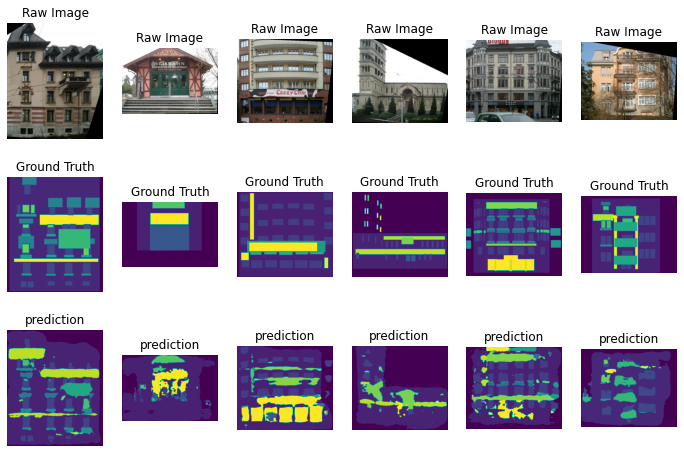

In [22]:
visualize(best_model_fcn8s, test_loader)

## Inline Questions(30%):

#### Inline Question 1: Why using pretrained model to initialized our model(FCN-32s) helps a lot? Please give at least two specific reasons

### Your Answer:
1. The main reason is that training from scratch is not feasible according to the experiment.
From the first section in this assignment and the experiment by authors(Long et al.), we can see the mean IU is increasing very slow.
This shows training from scratch is not working.

2. The underlying reason is that imagenet pretrain initialization helps initialization, because there is a lot of similarity between image classification task and our semantic segmentation task.
The similarity is that both tasks are for classification. The only difference is that the former is for image level classification, while the latter is for pixel level segmentation.
The former only need the global information, while the latter also need the local information. Overall, these two tasks are very similar.
Thus, imagenet classification weights can easily transfer to the semantic segmentaion task.

3. The similarity in weights lies in that, for the shallow layers, the two tasks share similar embeddings. Thus, only the weights in the deep layers would go through large change. That is why the pre-trained network trains faster.


#### Inline Question 2: Compare the performance and visualization of FCN-32s and FCN-8s. Please state the differnece, and provide some explanation. You can visualize more images than we provide, if it's necessary for you to see the difference.

### Your Answer:

The difference is that FCN-8s has higher mean IU and average accuracy than FCN-32s. The visualization shows that FCN-8s retains more details.

The reason for such difference is that, FCN-8s has coarse-to-fine 'skip' architecture. If we view the network as an encoder-decoder architecture, the 'skip' connection means we have a multi-resolution decoder. (The deep layer decoder takes the output of the previous layer decoder.)
Compared to the plain network, the multi-resolution decoder can obtain both the local and global information. It gets feature from different layers from the encoder, which are responsible for local and global information respectively.
The shallow layer retrieves the local information, while the deep layer gets the global information. Contrastly, the FCN-32s only has global information from the deepest encoded feature map. This is why its result is vague.